# **Laboratorio 3 - Informe**

### Grupo 4:
     - S. Calvo C.I 5.711.417-7     
     - X. Iribarnegaray C.I 5.253.705-9
     - J. Simonelli C.I 5.405.358-4

### **Objetivos**
El objetivo de este laboratorio es:
- Implementar funciones de AgenteRL para el ambiente open-ai gymnassium
- Analizar los resultados obtenidos luego de ejecuciones del agente entrenado
- Fundamentar la elección de los hiperparámetros utilizados

### **1. Bibliotecas**

In [1]:
!pip3 install cmake gymnasium scipy numpy gymnasium[box2d] pygame==2.6.0 swig
import sys
# Tal vez tengan que ejecutar lo siguiente en sus máquinas (ubuntu 20.04)
# sudo apt-get remove swig
# sudo apt-get install swig3.0
# sudo ln -s /usr/bin/swig3.0 /usr/bin/swig
# En windows tambien puede ser necesario MSVC++
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import json


Defaulting to user installation because normal site-packages is not writeable


## **2. Discretizando el estado**

El estado consiste de posiciones y velocidades en (x,y,theta) y en información de contacto de los pies con la superficie.

Como varios de estos son continuos, tenemos que discretizarlos para aplicar nuestro algoritmo de aprendizaje por refuerzo tabular.

In [2]:
# Cuántos bins queremos por dimensión
# Pueden considerar variar este parámetro
bins_per_dim = 20

# Estado:
# (x, y, x_vel, y_vel, theta, theta_vel, pie_izq_en_contacto, pie_derecho_en_contacto)
NUM_BINS = [bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, 2, 2]

env = gym.make('LunarLander-v2')
env.reset()

# Tomamos los rangos del env
OBS_SPACE_HIGH = env.observation_space.high
OBS_SPACE_LOW = env.observation_space.low
OBS_SPACE_LOW[1] = 0 # Para la coordenada y (altura), no podemos ir más abajo que la zona dea aterrizae (que está en el 0, 0)

# Los bins para cada dimensión
bins = [
    np.linspace(OBS_SPACE_LOW[i], OBS_SPACE_HIGH[i], NUM_BINS[i] - 1)
    for i in range(len(NUM_BINS) - 2) # last two are binary
]
# Se recomienda observar los bins para entender su estructura
# print ("Bins: ", bins)

def discretize_state(state, bins):
    """Discretize the continuous state into a tuple of discrete indices."""
    state_disc = list()
    for i in range(len(state)):
        if i >= len(bins):  # For binary features (leg contacts)
            state_disc.append(int(state[i]))
        else:
            state_disc.append(
                np.digitize(state[i], bins[i])
            )
    return tuple(state_disc)

## **3. Agentes y la interacción con el entorno**

Definimos una interfaz para nuestro agente:

In [3]:
class Agente:
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        """Elegir la accion a tomar en el estado actual y el espacio de acciones
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó
        """
        pass

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        """Aprender a partir de la tupla 
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó en esta transición
        """
        pass

    def fin_episodio(self):
        """Actualizar estructuras al final de un episodio"""
        pass

Luego definimos la función `ejecutar_episodio` para ejecutar un episodio con el agente AgenteRL:

In [4]:
def ejecutar_episodio(agente, aprender, render, max_iteraciones=500):
    if (render):
        entorno = gym.make('LunarLander-v2', render_mode='human').env
    else: 
        entorno = gym.make('LunarLander-v2').env
    
    iteraciones = 0
    recompensa_total = 0

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset()
    while iteraciones < max_iteraciones and not termino and not truncado:
        if render:
            entorno.render()
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n, aprender)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        if (aprender):
            agente.aprender(estado_anterior, estado_siguiente, accion, recompensa, termino)

        estado_anterior = estado_siguiente
        iteraciones += 1
        recompensa_total += recompensa
    if (aprender):
        agente.fin_episodio(recompensa_total)
    entorno.close()
    return recompensa_total

### **4. Programando un agente que aprende**

A continuación implementamos el agente:

In [5]:
class AgenteRL(Agente):
    # Pueden agregar parámetros al constructor
    def __init__(self, states, actions, gamma, initial_epsilon, final_epsilon, decay_factor) -> None:
        super().__init__()
        self.Q = np.zeros((states,actions))
        self.visits = np.zeros((states, actions))
        self.gamma = gamma
        self.epsilon = initial_epsilon
        self.final_epsilon = final_epsilon
        self.recompensa_maxima = -np.inf
        self.decay_factor = decay_factor
            
    def estado_discretizado_a_indice(self, estado_discretizado):
        return estado_discretizado[0] * 12800000 + estado_discretizado[1] * 640000 + estado_discretizado[2] * 32000 + \
           estado_discretizado[3] * 1600 + estado_discretizado[4] * 80 + estado_discretizado[5] * 4 + \
           estado_discretizado[6] * 2 + estado_discretizado[7]
           
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        estado_discretizado = discretize_state(estado, bins)
        row = self.estado_discretizado_a_indice(estado_discretizado)
        
        if explorar and np.random.random() < self.epsilon:
            return random.randrange(max_accion)  # Exploración
        else:
            return np.argmax(self.Q[row])  # Explotación
    
    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        discretized_state_anterior = discretize_state(estado_anterior, bins)
        discretized_state_siguiente = discretize_state(estado_siguiente, bins)
        
        row_anterior = self.estado_discretizado_a_indice(discretized_state_anterior)
        self.visits[row_anterior, accion] += 1
        alpha_n = 1 / self.visits[row_anterior, accion]

        row_siguiente = self.estado_discretizado_a_indice(discretized_state_siguiente)
        
        # Fórmula de actualización de Q-learning
        if not terminado:
            self.Q[row_anterior][accion] = (1 - alpha_n) * self.Q[row_anterior][accion] + alpha_n * (recompensa + self.gamma * np.max(self.Q[row_siguiente]))
        else:
            # Si el episodio terminó, no hay valor de futuro
            self.Q[row_anterior][accion] = (1 - alpha_n) * self.Q[row_anterior][accion] + alpha_n * (recompensa)

    def fin_episodio(self, recompensa_total):
        if recompensa_total > self.recompensa_maxima:
            self.recompensa_maxima = recompensa_total
            self.epsilon *= self.decay_factor
        self.epsilon = max(self.final_epsilon, self.epsilon)
        

#### **4.1 Diseño**

El agente es inicializado con una matriz Q de estados y acciones. Esta matriz almacena los valores de Q para cada par de estado y acción. Además, se lleva un registro de la cantidad de visitas (visits) que cada estado-acción ha tenido, lo que es utilizado para calcular el valor de alfa en el proceso de aprendizaje. 
Los parámetros de inicialización incluyen:

**gamma**: el factor de descuento, que pondera la importancia de las recompensas futuras.

**epsilon**: la probabilidad inicial de exploración, que va disminuyendo con el tiempo para promover la explotación del conocimiento adquirido.

**decay_factor**: el factor de decaimiento que decrementa el epsilon, y por lo tanto la tasa de exploración, con el tiempo.

Por cada iteración, el agente toma una decisión entre explorar o explotar, balanceando entre probar acciones nuevas y aprovechar las que han demostrado ser exitosas anteriormente. Si elige explorar, que esto sucede cuando toma un valor aleatorio entre 0 y 1 y este es menor a nuestro epsilon, selecciona una acción aleatoria entre las disponibles. Si elige explotar, selecciona la acción con el mayor valor Q asociado al estado actual.

In [6]:
entorno = gym.make('LunarLander-v2').env
episodios = 100_000
agente = AgenteRL(np.prod(NUM_BINS),entorno.action_space.n,1,initial_epsilon=1,final_epsilon=0.01,decay_factor=0.9)

exitos = 0
recompensa_acumulada_intervalo = []
exitos_intervalo_array = []
exitos_intervalo = 0
recompensas = []
epsilons = []
intervalos = 1000

for i in range(episodios):
    recompensa = ejecutar_episodio(agente, aprender=True, render=False)
    if (recompensa >= 200):
        exitos += 1
        exitos_intervalo += 1
    recompensa_acumulada_intervalo += [recompensa]
    if (i % intervalos == 0):
        print('Episodio', i,'- Promedio de últimas', intervalos ,'iteraciones: ', np.mean(recompensa_acumulada_intervalo),'- Epsilon:', agente.epsilon)
        recompensas.append(np.mean(recompensa_acumulada_intervalo))
        epsilons.append(agente.epsilon)
        exitos_intervalo_array.append(exitos_intervalo)
        exitos_intervalo = 0
        recompensa_acumulada_intervalo = []

Episodio 0 - Promedio de últimas 1000 iteraciones:  -341.3010920969851 - Epsilon: 0.9
Episodio 1000 - Promedio de últimas 1000 iteraciones:  -151.49566111064289 - Epsilon: 0.22876792454961012
Episodio 2000 - Promedio de últimas 1000 iteraciones:  -138.61310033895302 - Epsilon: 0.22876792454961012
Episodio 3000 - Promedio de últimas 1000 iteraciones:  -135.38929628939985 - Epsilon: 0.22876792454961012
Episodio 4000 - Promedio de últimas 1000 iteraciones:  -126.234009371675 - Epsilon: 0.2058911320946491
Episodio 5000 - Promedio de últimas 1000 iteraciones:  -124.03292888645039 - Epsilon: 0.2058911320946491
Episodio 6000 - Promedio de últimas 1000 iteraciones:  -118.75728935391156 - Epsilon: 0.1853020188851842
Episodio 7000 - Promedio de últimas 1000 iteraciones:  -118.93200473259496 - Epsilon: 0.1853020188851842
Episodio 8000 - Promedio de últimas 1000 iteraciones:  -117.4493789148108 - Epsilon: 0.1853020188851842
Episodio 9000 - Promedio de últimas 1000 iteraciones:  -111.23074930123447

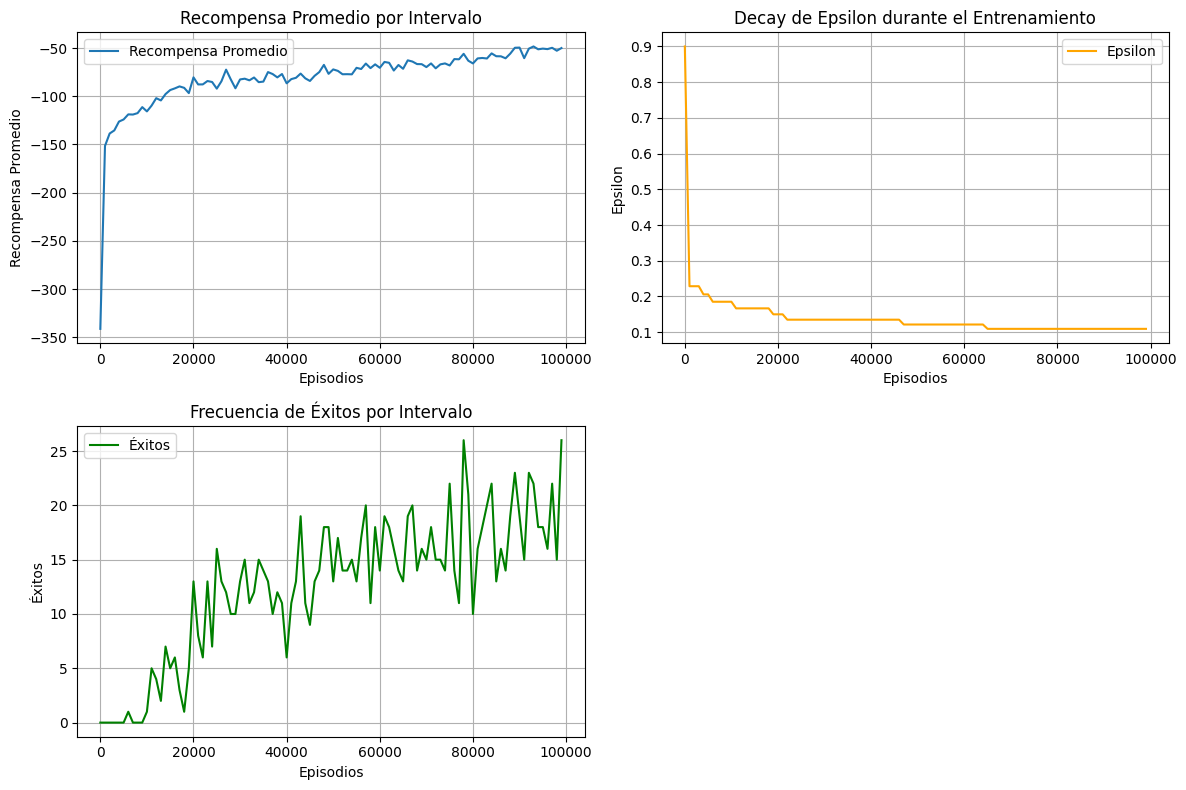

In [7]:

episodios_plot = range(0, episodios, intervalos)

# Crear la figura y los ejes
plt.figure(figsize=(12, 8))  # Cambiar el tamaño para acomodar mejor las tres gráficas

# Primera gráfica: Recompensas en función de episodios
plt.subplot(2, 2, 1)
plt.plot(episodios_plot, recompensas, label='Recompensa Promedio')
plt.xlabel('Episodios')
plt.ylabel('Recompensa Promedio')
plt.title('Recompensa Promedio por Intervalo')
plt.grid(True)
plt.legend()

# Segunda gráfica: Epsilon en función de episodios
plt.subplot(2, 2, 2)
plt.plot(episodios_plot, epsilons, label='Epsilon', color='orange')
plt.xlabel('Episodios')
plt.ylabel('Epsilon')
plt.title('Decay de Epsilon durante el Entrenamiento')
plt.grid(True)
plt.legend()

# Tercera gráfica: Éxitos en función de episodios
plt.subplot(2, 2, 3)
plt.plot(episodios_plot, exitos_intervalo_array, label='Éxitos', color='green')
plt.xlabel('Episodios')
plt.ylabel('Éxitos')
plt.title('Frecuencia de Éxitos por Intervalo')
plt.grid(True)
plt.legend()

# Ajustar automáticamente los espacios entre subplots
plt.tight_layout()

# Mostrar las gráficas
plt.show()


Analizar los resultados de la ejecución anterior, incluyendo:
 * Un análisis de los parámetros utilizados en el algoritmo (aprendizaje, política de exploración)
 * Un análisis de algunos 'cortes' de la matriz Q y la política (p.e. qué hace la nave cuando está cayendo rápidamente hacia abajo, sin rotación)
    * Definir los estados (filas) de la matriz Q que cumplan con las condiciones planteadas (caida libre sin rotación, hovering, quieto en el piso)
 * Un análisis de la evolución de la recompensa promedio
 * Un análisis de los casos de éxito
 * Un análisis de los casos en el que el agente falla
 * Qué limitante del agente de RL les parece que afecta más negativamente su desempeño. Cómo lo mejorarían? 

In [11]:
#ejecutar_episodio(agente, aprender=False, render=True, max_iteraciones=500)
#print()
exitos = 0
num_episodios = 1000
recompensa_episodios = []
for i in range(num_episodios):
    recompensa = ejecutar_episodio(agente, aprender=False, render=False)
    # Los episodios se consideran exitosos si se obutvo 200 o más de recompensa total
    if (recompensa >= 200):
        exitos += 1
        print('it', i, ' Exito: ',recompensa)
    recompensa_episodios += [recompensa]
    
print(f"Tasa de éxito: {exitos / num_episodios}. Se obtuvo {np.mean(recompensa_episodios)} de recompensa, en promedio")


it 56  Exito:  210.64344596280867
it 62  Exito:  235.09580404340608
it 71  Exito:  201.5255656693623
it 85  Exito:  202.49250048022682
it 88  Exito:  227.9026131198665
it 90  Exito:  207.21908736458676
it 100  Exito:  243.08496668094426
it 142  Exito:  254.25259767845978
it 151  Exito:  241.22625514563373
it 180  Exito:  209.70026792104503
it 196  Exito:  226.81801861915577
it 197  Exito:  227.9390507074375
it 211  Exito:  225.35761172910549
it 223  Exito:  242.9207201304916
it 251  Exito:  222.44350190481236
it 253  Exito:  242.75720574241183
it 287  Exito:  221.90335899407796
it 290  Exito:  235.0140786934479
it 297  Exito:  218.8010133851135
it 321  Exito:  215.2144469476725
it 327  Exito:  221.9009556412182
it 351  Exito:  206.13167373003074
it 406  Exito:  245.75069301525815
it 419  Exito:  216.439469322822
it 498  Exito:  226.6690980829704
it 507  Exito:  227.89888777242004
it 545  Exito:  234.3254990321915
it 555  Exito:  223.24690135910612
it 584  Exito:  237.31669655829222
it 